# Whisper Benchmark

## Set up env (outside notebook)

Run on terminal:

```
docker run -d -p 6379:6379 redis
celery -A tasks worker -P solo --loglevel=INFO
```

## Run tests

### Set up

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tasks import transcribe

audio_filename = 'stephen_fry.wav'

model_names = ['tiny.en', 'base.en', 'small.en']

/Users/vbernardes/miniforge3/envs/livekit39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Full transcription

In [74]:
n_runs = 10

for _ in range(n_runs):
    for model_name in model_names:
        transcribe.delay(audio_filename, model_name)

#### Results

In [ ]:
full_results = {name: pd.read_csv(f'performance_{name}.csv', header=None)[0] for name in model_names}
df_full = pd.DataFrame.from_dict(full_res, orient='columns')

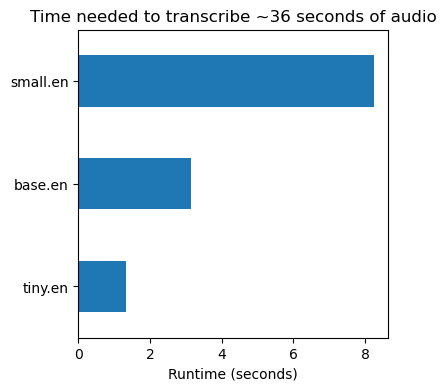

In [72]:
df_full.mean().plot.barh(figsize=(4,4))
plt.xlabel('Runtime (seconds)')
plt.title('Time needed to transcribe ~36 seconds of audio');

### Snippets

In [27]:
import audio2numpy as a2n
import numpy as np
import os
from uuid import uuid1
from scipy.io import wavfile

In [5]:
np_audio, sampling_rate = a2n.audio_from_file(audio_filename)

In [6]:
def split_audio(np_audio, chunk_seconds, sampling_rate=96000):
    indices = np.arange(sampling_rate*chunk_seconds, len(np_audio), sampling_rate*chunk_seconds)
    return np.split(np_audio, indices)

In [7]:
chunk_sizes = [2, 3, 5, 7]
snippets = {size: split_audio(np_audio, size, sampling_rate) for size in chunk_sizes}

In [55]:
temp_dir = 'tempfiles'
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

n_runs=10
for _ in range(n_runs):
    for size, snips in snippets.items():
        for model_name in model_names:
            for i, snip in enumerate(snips):
                temp_filename = str(uuid1())
                write_path = os.path.join(temp_dir, temp_filename) + '.wav'
                wavfile.write(write_path, sampling_rate, snip)
                transcribe.delay(write_path, model_name, chunk_size=size, counter=i)

#### Performance

In [58]:
snip_runtimes = {}
for model_name in model_names:
    snip_runtimes[model_name] = {}
    for size in chunk_sizes:
        snip_runtimes[model_name].update({
            size: pd.read_csv(f'performance_{model_name}_{size}secs.csv', header=None)[0]
        })

snip_results = {model_name: pd.DataFrame.from_dict(snip_runtimes[model_name], orient='columns') for model_name in model_names}

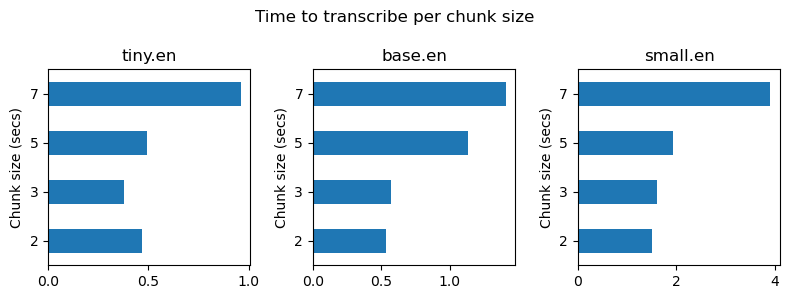

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(8,3))
for i, model_name in enumerate(model_names):
    snip_results[model_name].mean().plot.barh(ax=ax[i])
    ax[i].set_title(model_name)
    ax[i].set_ylabel('Chunk size (secs)')
fig.suptitle('Time to transcribe per chunk size');
plt.tight_layout()

### Transcripts

In [73]:
for model_name in model_names:
    for size in chunk_sizes:
        transcript = []
        for i in range(18):
            filename = f'transcription_{model_name}_{size}secs_{i}.txt'
            if os.path.exists(filename):
                with open(filename, 'r') as f:
                    transcript.append(f.readlines()[0])
        out_file = f'transcription_{model_name}_{size}secs.txt'
        with open(out_file, 'w') as f:
            f.write(''.join(transcript))